# Regularized Linear Models

## Lasso

The **Least Absolute Shrinkage and Selection Operator Regression**, simply called Lasso Regression is another regularized version of Linear Regression.  
It is used because it prefers non-zero coefficients, being used in **compressed sensing**. It's *cost function* is defined as: $$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n} |\theta_i|$$  
For the **gradient descent** in Lasso:
$$g(\theta, J) = \nabla_{\theta}MSE(\theta) + \alpha\begin{pmatrix} sign (\theta_1) \\ sign (\theta_2) \\ \vdots \\ sign(\theta_n) \end{pmatrix}$$
where
$$sign(\theta_i) = \begin{cases} -1, \theta_i < 0 \\ 0, \theta_i = 0 \\ +1, \theta_i > 0\end{cases}$$


In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit([[0, 0], [1, 1]], [0, 1])
lasso_reg.predict([[1, 5]])

array([0.8])

### Sci-kit learn example for Sparse Signal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

### Generate sparse data
np.random.seed(42)

n_samples, n_features = 50, 100

X = np.random.randn(n_samples, n_features)

# Decreasing coef with alternated signs
idx = np.arange(n_features)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0 # sparsify coef
y = np.dot(X, coef)

# Add noise
y += 0.01 * np.random.normal(size=n_samples)

# split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[: n_samples // 2], y[: n_samples // 2]
X_test, y_test = X[n_samples // 2 :], y[n_samples // 2 :]




In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
y_pred_reg = reg.fit(X_train, y_train).predict(X_test)
r2_score_reg = r2_score(y_test, y_pred_reg)
print(reg)
print("r^2 on linear regression : %f" % r2_score_reg)

LinearRegression()
r^2 on linear regression : 0.585659


In [ ]:
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1)
r^2 on test data : 0.658064


Text(0.5, 1.0, 'Lasso $R^2$: 0.658')

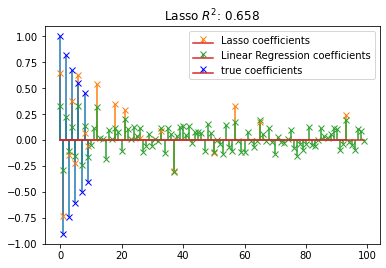

In [ ]:
m, s, _ = plt.stem(
    np.where(lasso.coef_)[0],
    lasso.coef_[lasso.coef_ != 0],
    markerfmt="x",
    label="Lasso coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#ff7f0e")
m, s, _ = plt.stem(
    np.where(reg.coef_)[0],
    reg.coef_[reg.coef_ != 0],
    markerfmt="x",
    label="Linear Regression coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#2ca02c")
plt.stem(
    np.where(coef)[0],
    coef[coef != 0],
    label="true coefficients",
    markerfmt="bx",
    use_line_collection=True,
)

plt.legend(loc="best")
plt.title(
    "Lasso $R^2$: %.3f" % (r2_score_lasso)
)

## Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both controled by the mix ration r. When r = 0, Elastic Net is equivalent to Ridge, and when r=1, it is equivalent to Lasso. It's cost equation is the following:  
$$ J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_i^2 $$
Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated

### Scikit learn implementation and example

In [ ]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.1, l1_ratio = 0.5)
enet.fit([[0, 0], [1, 1]], [0, 1])
enet.predict([[1, 5]])

array([2.31795741])

## Scikit learn Compressive sensing and tomography Lasso Example

In [ ]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [ ]:
## Functions

def _weights(x, dx=1, orig=0):
  x = np.ravel(x)
  floor_x = np.floor((x - orig)/dx).astype(np.int64)
  alpha = (x - orig - floor_x*dx) / dx
  return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

def _generate_center_coordinates(l_x):
  X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
  center = l_x / 2.0
  X += 0.5 - center
  Y += 0.5 - center
  return X, Y

def build_projection_operator(l_x, n_dir):
  #compute te tomography design matrix
  # l_x = linear size of image array
  # n_dir = number of angles at which projectiosn are acquired
  X, Y = _generate_center_coordinates(l_x)
  angles = np.linspace(0, np.pi, n_dir, endpoint=False)
  data_inds, weights, camera_inds = [], [], []
  data_unravel_indices = np.arange(l_x ** 2)
  data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
  for i, angle in enumerate(angles):
    Xrot = np.cos(angle) * X - np.sin(angle) * Y
    inds, w = _weights(Xrot, dx=1, orig=X.min())
    mask = np.logical_and(inds >= 0, inds < l_x)
    weights += list(w[mask])
    camera_inds += list(inds[mask] + i * l_x)
    data_inds += list(data_unravel_indices[mask])
  proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
  return proj_operator

def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [ ]:
# Generate synthetic images and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

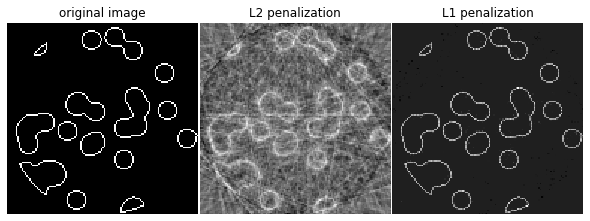

In [ ]:
plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()